# Fitting Spot Rates with Nelson Siegel and Nelson Siegel Svensson models

In this workbook, the second on the Nelson-Siegel-Svensson model, we want to fit a given spot curve.

The standard approach to fit a given curve with the NSS model is to set values for $T1$ and $T2$ (in (1) and (2) below), and then run linear regressions to estimate the betas (in (1) and (2)). Infact, once $T1$ and $T2$ are fixed, the models become linear.

Doing this over a selected range of values for $T1$ and $T2$ should allow to select that combination of betas and Ts with the lowest mean square errors.  

The spot curve we extracted from the previous notebook is perfect for this exercise as it is very non-linear.

We write below the two parametric functions for the zero rate  $r(0,t)$ we used in the previous workbook.

In the Nelson Siegel and  Nelson Siegel Svensson models, the zero rate respectively follows the parametric equations:

\begin{equation} (1) \ Nelson\ Siegel :\  
r(0,t) = \beta_0 + \beta_1\left(\frac{1-e^{\left(\frac{-t}{T_1}\right)}}{t/T_1} \right) + \beta_2\left(\frac{1-e^{\left(\frac{-t}{T_1}\right)}}{t/T_1} - e^{\frac{-t}{T_1}} \right) \end{equation}

\begin{equation} (2) \ Nelson\ Siegel\ Svensson :\
r(0,t) = \beta_0 + \beta_1\left(\frac{1-e^{\left(\frac{-t}{T_1}\right)}}{t/T_1} \right) + \beta_2\left(\frac{1-e^{\left(\frac{-t}{T_1}\right)}}{t/T_1} - e^{\frac{-t}{T_1}} \right) + 
\beta_3 \left( \frac{1-e^{\left(\frac{-t}{T_2}\right)}}{t/T_2} -e^{\frac{-t}{T_2}} \right)
\end{equation}

where:

-  $r(0,t)$: zero rate with maturity $t$
-  $\beta_0$: level parameter, the long term rate
-  $\beta_1$: slope parameter, the spread short/long-term
-  $\beta_2$: first curvature or hump parameter
-  $\beta_3$: second curvature or hump parameter which allows for a better fit at long maturities

-  $T_1$: scale parameter which affects both the slope and first curvature $\beta_1$ and $\beta_2$
-  $T_2$: scale parameter for the second hump parameter $\beta_3$

where $T_2$ and $\beta_3$ are only valid for the NSS model.  

We start by importing the python libraries we need

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import statsmodels.api as sm
%matplotlib inline

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Let's import our data set:

In [2]:
SpotRates = pd.read_csv ('SpotRates.csv', index_col=0)
print (SpotRates.head(2))
print (SpotRates.tail(2))
size = len(SpotRates)

   Times  SpotRates_NS  SpotRates_NSS
0    0.5      0.062211       0.059913
1    1.0      0.059136       0.058687
    Times  SpotRates_NS  SpotRates_NSS
54   27.5      0.057814       0.056507
55   28.0      0.057831       0.056348


In [3]:
print (SpotRates.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56 entries, 0 to 55
Data columns (total 3 columns):
Times            56 non-null float64
SpotRates_NS     56 non-null float64
SpotRates_NSS    56 non-null float64
dtypes: float64(3)
memory usage: 1.8 KB
None


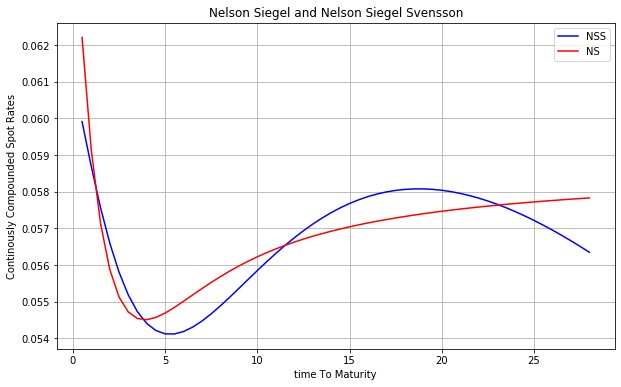

In [4]:
plt.figure(figsize=(10,6))
plt.plot(SpotRates.Times, SpotRates.SpotRates_NSS, lw=1.5, color='blue', label ='NSS')
plt.plot(SpotRates.Times, SpotRates.SpotRates_NS,  lw=1.5, color='red', label ='NS')
plt.legend()
plt.xlabel('time To Maturity')  
plt.ylabel('Continously Compounded Spot Rates')
plt.grid(True)
plt.title("Nelson Siegel and Nelson Siegel Svensson");
plt.show()

Let's load the Nelson Siegel Svensson algos previously prepared.

In [5]:
from NelsonSiegelSvenssonModels import *

Let's run some sanity checks to ensure that we are using the same spot curves we extracted from the bond prices in the previous notebook.

These are the parameters from the previous notebook, so if we use them in the NSS and NS classes, 
we should match the values in the dataframe  SpotRates

NSS : [0.01919787; 0.04195236; 0.0214226;  0.115158770;  1.4858585858585862;  12.73090909090909]

NS  : [0.05874207, 0.00810001,-0.02527748, 1.4858585858585862]


In [6]:
nss = NelsonSiegelSvensson(size)
nss.set_ws([0.01919787, 0.04195236, 0.0214226 , 0.11515877])
nss.set_NL0(1.4858585858585862)
nss.set_NL1(12.73090909090909)

print("for time = 0.5 ")
print (nss.zerorate(1))
print (SpotRates.SpotRates_NSS[1])
print("for time = year 28 ")
print (nss.zerorate(28))
print (SpotRates.SpotRates_NSS[55])

for time = 0.5 
0.05868695629598196
0.05868695689931298
for time = year 28 
0.05634754063773187
0.05634754156864576


In [7]:
ns = NelsonSiegel(size)
ns.set_ws([ 0.05874207,  0.00810001, -0.02527748])
ns.set_NL(1.4858585858585862)

print("for time = 0.5 ")
print (ns.zerorate(1))
print (SpotRates.SpotRates_NS[1])
print("for time = year 28 ")
print (ns.zerorate(28))
print (SpotRates.SpotRates_NS[55])

for time = 0.5 
0.05913580091232008
0.059135802093526466
for time = year 28 
0.05783052405420459
0.05783052644554786


In [8]:
# and let's check all of them for the NS model
Matrix_NS = np.zeros((size,3))
for i, val in enumerate(SpotRates.Times):
    Matrix_NS[i] = ns.ols(val) 
print (np.mean((SpotRates.SpotRates_NS - Matrix_NS.dot(ns.w))**2))
#correct. the mean square of differences is virtually zero!

4.0223844547781705e-18


In [9]:
# and for the NSS model
Matrix_NSS = np.zeros((size,4))
for i, val in enumerate(SpotRates.Times):
    Matrix_NSS[i] = nss.ols(val) 
np.mean((SpotRates.SpotRates_NSS - Matrix_NSS.dot(nss.w))**2)   
#correct. the mean square of differences is virtually zero!

5.604735667391415e-19

The idea is to set $T1$ and $T2$ to some values and then run a Linear Regression on SpotRates.SpotRates_NS and $r(0,t)$ (as calculated in (2)). 

With $T1$ = 1.486 and $T2$ = 12.73, the model is now linear and we should retrieve a parameter vector equal to the $w$ of the NSS model as reported above.

So before running a regression, let's check this is the case, as we already know parameter vector

The $y$  vector is the vector the Spot Rates from the NSS model in the dataset  

In [10]:
y = np.asarray(SpotRates.SpotRates_NSS)

In [11]:
results = sm.OLS(y, Matrix_NSS).fit()
print (results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.564e+27
Date:                Wed, 08 Apr 2020   Prob (F-statistic):               0.00
Time:                        18:01:27   Log-Likelihood:                 1992.4
No. Observations:                  56   AIC:                            -3977.
Df Residuals:                      52   BIC:                            -3969.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0192   6.97e-16   2.76e+13      0.0

In [12]:
print(results.params)
print(nss.w)

[0.01919787 0.04195236 0.0214226  0.11515877]
[0.01919787, 0.04195236, 0.0214226, 0.11515877]


We are going to start with the Nelson Siegel model to set the T1 

In [13]:
Size         = 100
xT1          = np.linspace(0.1, 5.0, num = Size)
yNsPriceDiff = np.zeros((Size,2))

for i, val in enumerate(xT1):
    # set the T1 value
    ns.set_NL(val)
    # Prepare the Matrix 
    for j, valore in enumerate(SpotRates.Times):
        Matrix_NS[j] = ns.ols(valore) 
    
    # linear fit
    resultsNS = sm.OLS(y, Matrix_NS).fit()
    ns.w      = resultsNS.params
    Residuals = np.mean((SpotRates.SpotRates_NSS - Matrix_NS.dot(ns.w))**2)    
    yNsPriceDiff[i,0] = Residuals
    yNsPriceDiff[i,1] = val    

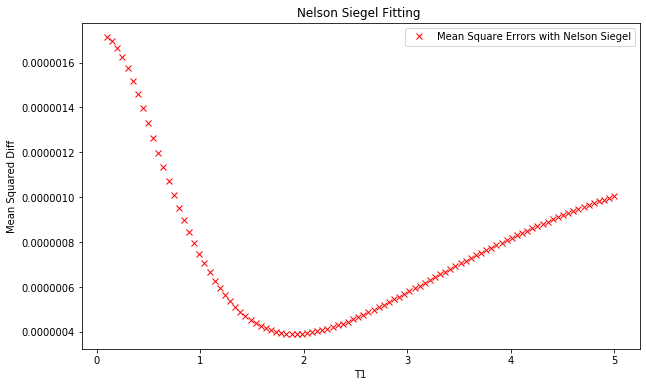

In [14]:
plt.figure(figsize=(10,6))
plt.plot(xT1, yNsPriceDiff[:,0], 'x', color='red', label ='Mean Square Errors with Nelson Siegel')
plt.legend()
plt.ylabel('Mean Squared Diff')
plt.xlabel('T1')
plt.title("Nelson Siegel Fitting ");        
plt.show()

In [15]:
# Let's find the T1 value where we achieve the lowest Mean Square Error
minValue =  np.min(yNsPriceDiff[:,0])
index    =  np.where(yNsPriceDiff[:,0]== minValue)
valT1    =  yNsPriceDiff[index[0][0],1]
print(minValue)
print(valT1)

3.9048570377110817e-07
1.9313131313131315


In [16]:
# set the T1 value
ns.set_NL(valT1)
# Prepare the Matrix 
for j, valore in enumerate(SpotRates.Times):
    Matrix_NS[j] = ns.ols(valore) 
    
# linear fit
resultsNS = sm.OLS(y, Matrix_NS).fit()
print(resultsNS.params)
print(ns.w)

ns.w = (resultsNS.params)
# some differences as we have fitted the NS model on the spot curve of the NSS model

[ 0.05917325  0.00429581 -0.02170943]
[ 0.06157675 -0.00333951 -0.01496544]


We have now a guess for the $T1$ and we are going to use it for the NSS

In [17]:
nss.set_NL0(valT1)

Size          = 100
xT2           = np.linspace(0.01, 20.0, num = Size)
yNssPriceDiff = np.zeros((Size,2))

for i, val in enumerate(xT2):
    # set the T1 value
    nss.set_NL1(val)
    # Prepare the Matrix 
    for j, valore in enumerate(SpotRates.Times):
        Matrix_NSS[j] = nss.ols(valore) 
    
    # linear fit
    resultsNSS = sm.OLS(y, Matrix_NSS).fit()
    nss.w      = resultsNSS.params
    Residuals  = np.mean((SpotRates.SpotRates_NSS - Matrix_NSS.dot(nss.w))**2)    
    yNsPriceDiff[i,0] = Residuals
    yNsPriceDiff[i,1] = val    


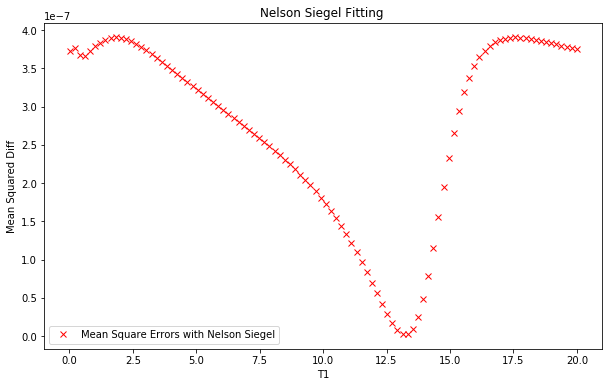

In [18]:
plt.figure(figsize=(10,6))
plt.plot(xT2, yNsPriceDiff[:,0], 'x', color='red', label ='Mean Square Errors with Nelson Siegel')
plt.legend()
plt.ylabel('Mean Squared Diff')
plt.xlabel('T1')
plt.title("Nelson Siegel Fitting ");        
plt.show()

In [19]:
# Let's find the T2 value where we achieve the lowest Mean Square Error
minValue =  np.min(yNsPriceDiff[:,0])
index    =  np.where(yNsPriceDiff[:,0]== minValue)
valT2    =  yNsPriceDiff[index[0][0],1]
print(minValue)
print(valT2)

2.6364036557771564e-09
13.134747474747474


In [20]:
# set the T2 value
nss.set_NL1(valT2)
# Prepare the Matrix 
for j, valore in enumerate(SpotRates.Times):
    Matrix_NSS[j] = nss.ols(valore) 
    
# linear fit
resultsNSS = sm.OLS(y, Matrix_NSS).fit()
print (resultsNSS.params)
print (nss.w)
nss.w   = resultsNSS.params

[0.01377467 0.04812169 0.01417629 0.12957231]
[ 0.0638949   0.00031901 -0.02833832 -0.01414381]


In [21]:
for j, valore in enumerate(SpotRates.Times):
    ns.r[j]  = ns.zerorate(valore) 
    nss.r[j] = nss.zerorate(valore) 

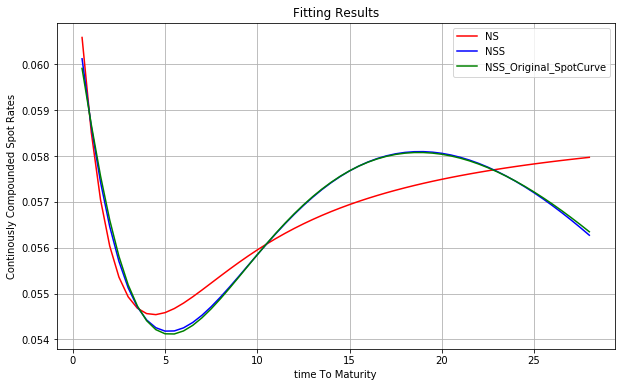

In [22]:
plt.figure(figsize=(10,6))
plt.plot(SpotRates.Times, ns.r,  lw=1.5,  color='red', label ='NS')
plt.plot(SpotRates.Times, nss.r, lw=1.5,  color='blue', label ='NSS')
plt.plot(SpotRates.Times, SpotRates.SpotRates_NSS, lw=1.5, color='green', label ='NSS_Original_SpotCurve')
plt.xlabel('time To Maturity')  
plt.ylabel('Continously Compounded Spot Rates')
plt.grid(True)
plt.title("Fitting Results");
plt.legend()
plt.show()

We could further improve the NSS fitting by choosing $T1$ and $T2$ around a much smaller interval around 1.93 and 13.13 respectively.

The NS fitting is instead poor on this data set as it is not able to match the second hump in the data.  